## Análise dos Salários da Unidade de San Francisco  

**Contexto:**  
Nesse projeto (**Fictício**), tive a oportunidade de apresentar minha expertise ao CEO da **Hidden Analysis**, que me propôs extrair insights da Agência de San Francisco. Ele deixou claro que precisava desse projeto até amanhã de manhã. Caso eu me sinta pressionado, ele sugeriu que posso convocar um analista do RH para ajudar.  

### Exigências dele:  

1. Qual foi a evolução do salário médio ao longo dos anos (TotalPay e TotalPayBenefits).  
2. Quantos funcionários tivemos ao longo dos anos.  
3. Qual foi a maior média salarial registrada e em que ano isso ocorreu, com base no cargo?  
4. Qual foi a evolução do total gasto com salário ao longo dos anos (TotalPayBenefits).  
5. Prever, nesse ritmo, a evolução dos salários médios nos próximos 5 anos.

--- 


In [171]:
# Importações necessárias
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Modelos de IA
from sklearn.linear_model import LinearRegression

# Paleta de cores
cores = plt.get_cmap('Pastel2').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

paletas = plt.get_cmap('Set2').colors# pegar paleta de cor nova


**Importando a base e entendimento do desafio inicial**

- Para extrair minha base com os salários, vou usar a integração de **Python** com **SQL** e transformar em um DataFrame. Aí sim começa a limpeza.


In [153]:
#CONEXAO
bancoDados = ("Driver={SQLite3 ODBC Driver};Server=localhost;Database=./salarios.sqlite")
conexao = pyodbc.connect(bancoDados)
cursor = conexao.cursor()

comando = """ 
SELECT * FROM Salaries
"""
cursor.execute(comando)
valores = cursor.fetchall()

descricao = cursor.description
descricao[0]

('Id', int, None, 10, 10, 0, True)

- Notei que o retorno do primeiro item foi uma tupla, e seu primeiro valor é o nome da coluna.  

- Usarei essa lista de colunas para criar uma tabela principal de valores.  


In [154]:
colunas = [tupla[0] for tupla in descricao]# Criando uma lista de colunas

tabela = pd.DataFrame.from_records(valores, columns= colunas)
tabela.to_csv('tabela_salarios.csv',index=False)# Salvar tabela em .csv

display(tabela.head())
display(tabela.shape)

# Fechar conexao
cursor.close()
conexao.close()


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011,,San Francisco,
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,,San Francisco,
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011,,San Francisco,
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011,,San Francisco,
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011,,San Francisco,


(148654, 13)

### Inicio da Análise de Dados

- Preciso lembrar que essa análise é direcionada para Agência de São Francisco.

- Então desdo inicio tenho que filtrar minha analise só valores da coluna Agency for igual 'San Francisco'.

In [155]:
# O argumento 'low_memory = False' é usado para evitar o consumo excessivo de memória para arquivos grandes
tabela_salarios = pd.read_csv('tabela_salarios.csv',low_memory=False).loc[tabela['Agency'] == 'San Francisco', :]
display(tabela_salarios.head())

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


Tabela que mostra valores *Nulos* / *NaN*

In [156]:
tabela_nan = tabela_salarios.isnull().groupby('Id')[tabela_salarios.columns].sum()
display(tabela_nan)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
Id,,,,,,,,,,,,,
False,0,0,0,609,4,4,36163,0,0,0,148654,0,110535


Observe que existem vários NaN nesta tabela. Como o foco inicial serão nas colunas **TotalPay , TotalPayBenefits , Year e Id** , e todas elas estão totalmente preenchidas, não irei limpar essa tabela ainda. Quero usar esses valores brutos.

In [172]:
# Função para formatar formato de moeda
def formatacao(valor):
    return 'R${:_.2f}'.format(valor).replace('.',',').replace('_','.')

# Função que mostra qual é a correlação de uma coluna em um DataFramer
def grafico_corr(df,coluna):
    plt.figure(figsize=(15,6))
    corr = sns.heatmap(df.corr()[[f'{coluna}']], 
                annot=True, 
                cmap='Blues',color=paletas[2])

    corr.set_title(f'\nCorrelação das variáveis ​​com a coluna {coluna}\n',
                   fontdict={'fontsize':18},alpha=0.8)
    corr.set_xticklabels([]) # retirar os tiks
    plt.show()

# Função para formatar os valores do eixo Y.
def format_ticks(value, _):
    return f"{value/1000:.0f}mi"

# Função retorna os valores do eixo Y.
def posicao_y(pos):
    return float(plt.yticks()[1][pos].get_text())

##### 1. Qual foi a evolução do salário médio ao longo dos anos?


,TotalPay,TotalPayBenefits
Year,,
2011,"R$71.744,10","R$71.744,10"
2012,"R$74.113,26","R$100.553,23"
2013,"R$77.611,44","R$101.440,52"
2014,"R$75.463,92","R$100.250,92"


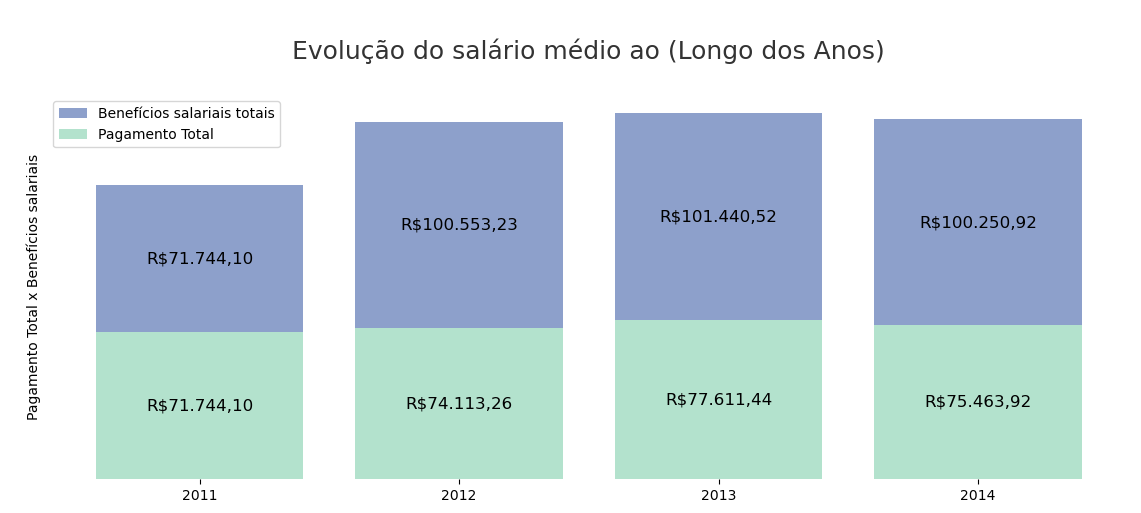

In [173]:
tabela_media = tabela.groupby('Year')[['TotalPay','TotalPayBenefits']].mean()

year = tabela_media.index.values
pagamento_total = tabela_media['TotalPay'].values
beneficios_salariais_totais = tabela_media['TotalPayBenefits'].values


fig, ax = plt.subplots(figsize=(14,5))

# Barras de benefícios salariais totais (empilhadas)
barras_beneficios = ax.bar(year,beneficios_salariais_totais,label = 'Benefícios salariais totais',bottom = pagamento_total,color  = paletas[2])
plt.bar_label(barras_beneficios,
              labels=[formatacao(v) for v in beneficios_salariais_totais],
              label_type='center',
              fontsize=12,
              color='black')

# Barras de pagamento total
barras_pagamento = ax.bar(year,pagamento_total,label='Pagamento Total')
plt.bar_label(barras_pagamento,
              labels=[formatacao(v) for v in pagamento_total],
              label_type='center',
              fontsize=12,
              color='black')



ax.set_title('\nEvolução do salário médio ao (Longo dos Anos)\n',fontsize=18,alpha=0.8)
ax.set_ylabel('\nPagamento Total x Benefícios salariais')
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])
ax.legend()
ax.set_frame_on(False)

# Aplica formatação personalizada às colunas de médias no DataFrame.
tabela_media['TotalPay'] = tabela_media['TotalPay'].apply(formatacao)
tabela_media['TotalPayBenefits'] = tabela_media['TotalPayBenefits'].apply(formatacao)
display(tabela_media)

plt.show()

* **Crescimento:** Observa-se um crescimento consistente nos salários médios ao longo dos anos analisados, tanto no que se refere ao pagamento base quanto aos benefícios. Isso indica uma tendência positiva na remuneração dos colaboradores.


##### 2. Quantos funcionários tivemos ao longo dos anos?

,Funcionarios
Year,
2011,"36,159mil"
2012,"36,766mil"
2013,"37,606mil"
2014,"38,123mil"


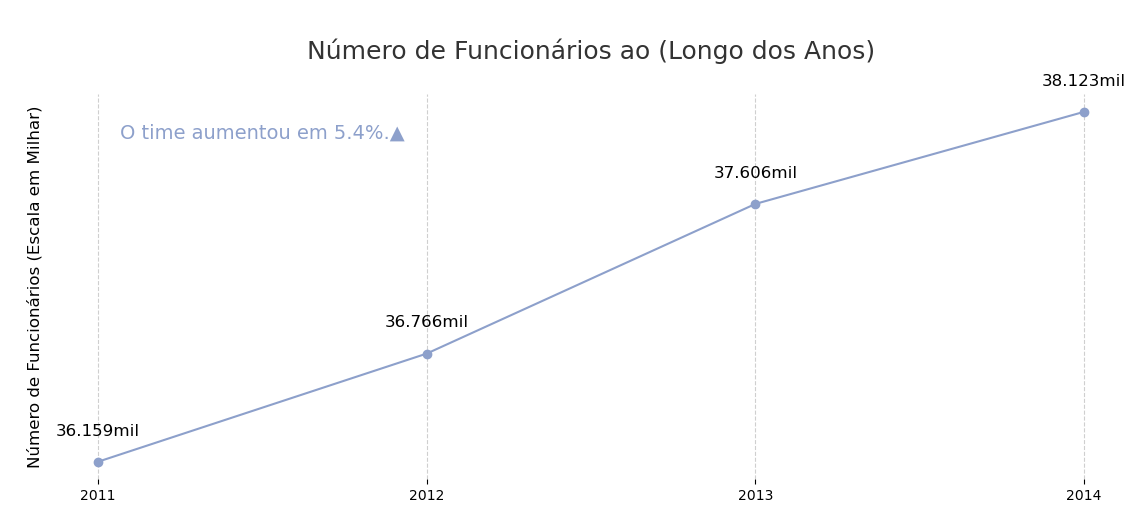

In [175]:
tabela_funcionarios = tabela.groupby('Year')[['Id']].count()
tabela_funcionarios = tabela_funcionarios.rename(columns={'Id':'Funcionarios'})
funcionarios = tabela_funcionarios['Funcionarios'].values

# Calculando o valor de crescimento
crescimento = (funcionarios[-1] - funcionarios[0]) / funcionarios[0]

# Iniciando meu grafico
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(year, funcionarios, marker='o', color=paletas[2], label="Funcionários")

# Adicionando rótulos diretamente nos pontos
for x, y in zip(year, funcionarios):
    ax.text(x, y + 150, f"{y:,}mil".replace(',','.'), ha='center', fontsize=12,color='black')

# Configurações do grafico
ax.set_title("\nNúmero de Funcionários ao (Longo dos Anos)\n", fontsize=18,alpha=0.8)

# Dividi os valores de x com year[len(year)//4] - 0.5
# Ajustei a altura de y com max(funcionarios) - 150

ax.text(year[len(year)//4] - 0.5, max(funcionarios) - 150,"O time aumentou em {:.1%}.▲".format(crescimento),fontsize=14,color=paletas[2],ha='center')
ax.set_ylabel("\nNúmero de Funcionários (Escala em Milhar)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])

# Aplica formatação personalizada na coluna.
tabela_funcionarios['Funcionarios'] = tabela_funcionarios['Funcionarios'].apply('{:,.0f}mil'.format)
display(tabela_funcionarios)

plt.show()


* **Aumento no número de funcionários:** O número de funcionários também apresentou um crescimento no período de 4 anos, o que pode ter influenciado o aumento do gasto total com salários, embora tenha sido um aumento pequeno.


##### 3. Qual foi a maior média salarial registrada e em que ano isso ocorreu, com base no cargo?

,Ano,CargoTotalPay,MaiorMediaTP,CargoTotalPayBenefits,MaiorMediaTPB
0,2011,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,"R$399.211,28",GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,"R$399.211,28"
1,2012,Chief of Police,"R$321.552,11",Chief of Police,"R$391.362,30"
2,2013,Chief of Police,"R$339.282,07",Chief of Police,"R$425.815,28"
3,2014,Chief Investment Officer,"R$339.653,70",Chief Investment Officer,"R$436.224,36"


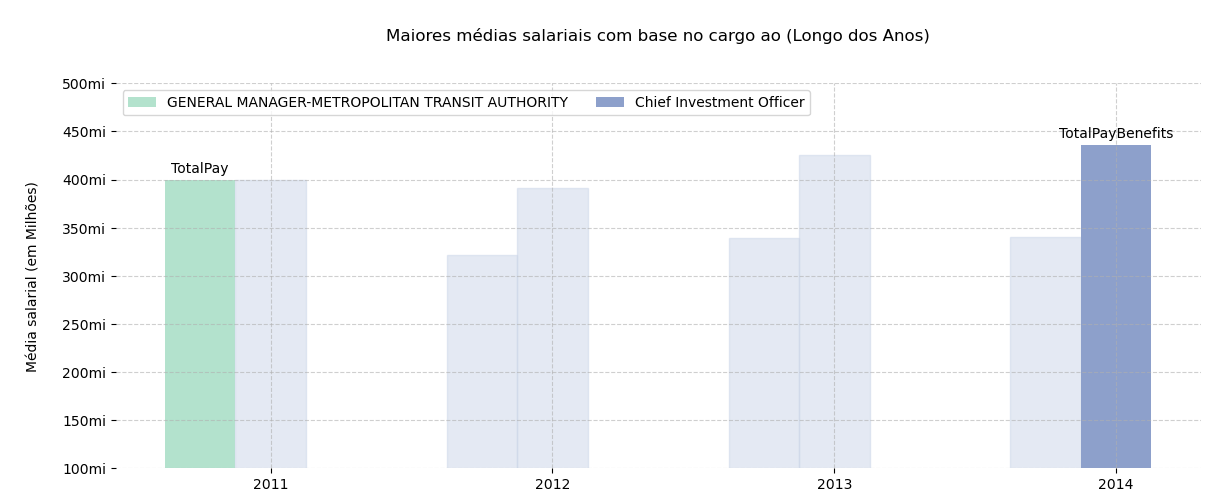

In [160]:
# Copia a tabela original para não alterar os dados originais.
tabela_maior_media = tabela.copy()

# Inicializa uma lista para armazenar os resultados calculados para cada ano.
tupla_armazenar = []

# Loop para processar cada ano único na tabela.
for coluna in tabela_maior_media['Year'].unique():
    # Filtra a tabela para incluir apenas os dados do ano atual.
    tabela_anos = tabela_maior_media[tabela_maior_media['Year'] == coluna]
    
    # Agrupa os dados por cargo ('JobTitle') e calcula a média de 'TotalPay' e 'TotalPayBenefits'.
    tabela_anos = tabela_anos.groupby('JobTitle')[['TotalPay', 'TotalPayBenefits']].mean()

    # Identifica o cargo com maior média de 'TotalPay' e 'TotalPayBenefits' e seus valores.
    tupla_armazenar.append((
        coluna,                                  # Ano
        tabela_anos['TotalPay'].idxmax(),       # Cargo com maior média em TotalPay
        tabela_anos['TotalPay'].max(),          # Maior média em TotalPay
        tabela_anos['TotalPayBenefits'].idxmax(),  # Cargo com maior média em TotalPayBenefits
        tabela_anos['TotalPayBenefits'].max()   # Maior média em TotalPayBenefits
    ))

# Cria um DataFrame a partir da lista armazenada com colunas nomeadas.
tabela_maior_media = pd.DataFrame(
    tupla_armazenar, 
    columns=['Ano', 'CargoTotalPay', 'MaiorMediaTP', 'CargoTotalPayBenefits', 'MaiorMediaTPB']
)

# Extrai as colunas de interesse em arrays separados para uso no gráfico.
pagamento_total = tabela_maior_media['MaiorMediaTP'].values
beneficios_salariais_totais = tabela_maior_media['MaiorMediaTPB'].values
cargos = tabela_maior_media['CargoTotalPay'].values
year = tabela_maior_media['Ano'].values

# Cria um dicionário para armazenar as médias salariais e de benefícios.
penguin_means = {
    'TotalPay': pagamento_total,
    'TotalPayBenefits': beneficios_salariais_totais,
}

x = np.arange(len(year))  # Posições no eixo X
largura = 0.25           # Largura das barras
multiplica = 0           # Multiplicador para calcular o deslocamento das barras

# Rótulos para os maiores valores em cada categoria.
rotulos_pt = [list(penguin_means.keys())[0] if valor == max(pagamento_total) else '' for valor in pagamento_total]
rotulos_tpb = [list(penguin_means.keys())[1] if valor == max(beneficios_salariais_totais) else '' for valor in beneficios_salariais_totais]

fig, ax = plt.subplots(figsize=(14, 5))

# Loop para criar as barras para cada categoria ('TotalPay' e 'TotalPayBenefits').
for chave, valor in penguin_means.items():
    offset = largura * multiplica  # Calcula o deslocamento da barra com base no índice.
    
    if chave == 'TotalPay':
        # Adiciona as barras para 'TotalPay' com uma leve diferença na altura (+150).
        rects = ax.bar(
            x + offset, valor + 150, largura, 
            label=cargos[tabela_maior_media['MaiorMediaTP'].idxmax()]
        )
        ax.bar_label(rects, padding=3, labels=rotulos_pt)  # Adiciona os rótulos nas barras.
        multiplica += 1  # Incrementa o multiplicador.
        
        # Altera a cor e a transparência das barras que não representam o valor máximo.
        for i, bar in enumerate(rects):
            if i != list(pagamento_total).index(max(list(pagamento_total))):
                rects[i].set_color(cores[2])
                rects[i].set_alpha(0.5)

    else:
        # Adiciona as barras para 'TotalPayBenefits' com cor definida.
        rects = ax.bar(
            x + offset, valor, largura, 
            label=cargos[tabela_maior_media['MaiorMediaTPB'].idxmax()],
            color=paletas[2]
        )
        ax.legend(loc='upper left', ncols=2)  # Adiciona a legenda no canto superior esquerdo.
        ax.bar_label(rects, padding=3, labels=rotulos_tpb)  # Adiciona os rótulos nas barras.
        multiplica += 1  # Incrementa o multiplicador.

        # Altera a cor e a transparência das barras que não representam o valor máximo.
        for i, bar in enumerate(rects):
            if i != list(beneficios_salariais_totais).index(max(list(beneficios_salariais_totais))):
                rects[i].set_color(cores[2])
                rects[i].set_alpha(0.5)

# Configurações do gráfico
ax.set_ylabel('\nMédia salarial (em Milhões)\n')  # Rótulo do eixo Y.
ax.set_title("\nMaiores médias salariais com base no cargo ao (Longo dos Anos)\n\n", fontsize=12)  # Título.
ax.set_xticks(x + largura, year)  # Configura os ticks do eixo X.
ax.set_ylim(100_000, 500_000)  # Ajusta os limites do eixo Y.
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)

# Função para formatar os valores do eixo Y.
def format_ticks(value, _):
    return f"{value/1000:.0f}mi"

# Aplica a formatação personalizada ao eixo Y.
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))


# Aplica formatação personalizada às colunas de médias no DataFrame.
tabela_maior_media['MaiorMediaTP'] = tabela_maior_media['MaiorMediaTP'].apply(formatacao)
tabela_maior_media['MaiorMediaTPB'] = tabela_maior_media['MaiorMediaTPB'].apply(formatacao)
display(tabela_maior_media)

plt.show()


* **Variação salarial:** Houve uma grande variação salarial entre as diferentes cargas, especialmente no ano de 2012, quando ocorreu uma mudança significativa nas políticas da empresa ou em uma tendência do mercado. Essa mudança resultou em uma redução no pagamento total e em um reajuste nos benefícios salariais. Nos anos seguintes, observamos uma tendência de crescimento contínuo.
 
* **Crescimento:** As cargas de liderança tiveram um crescimento salarial mais expressivo nos últimos anos. Esse fato pode estar relacionado à necessidade de atrair e reter talentos nesses níveis estratégicos.

* **Maior média salarial registrada por categoria ao longo dos anos:**

    - Pagamento total:

        - (2011) Gerente Geral – Autoridade Metropolitana de Trânsito: **R$ 399.211,28**

    - Benefícios do TotalPay:

        - (2014) Diretor de Investimentos: **R$ 436.224,36**




##### 4. Qual foi a evolução do total gasto com salário ao longo dos anos?

,TotalPay,TotalPayBenefits
Year,,
2011,"R$2.594.195.051,88","R$2.594.195.051,88"
2012,"R$2.724.848.200,44","R$3.696.940.025,96"
2013,"R$2.918.655.930,80","R$3.814.772.184,37"
2014,"R$2.876.910.951,26","R$3.821.865.780,60"


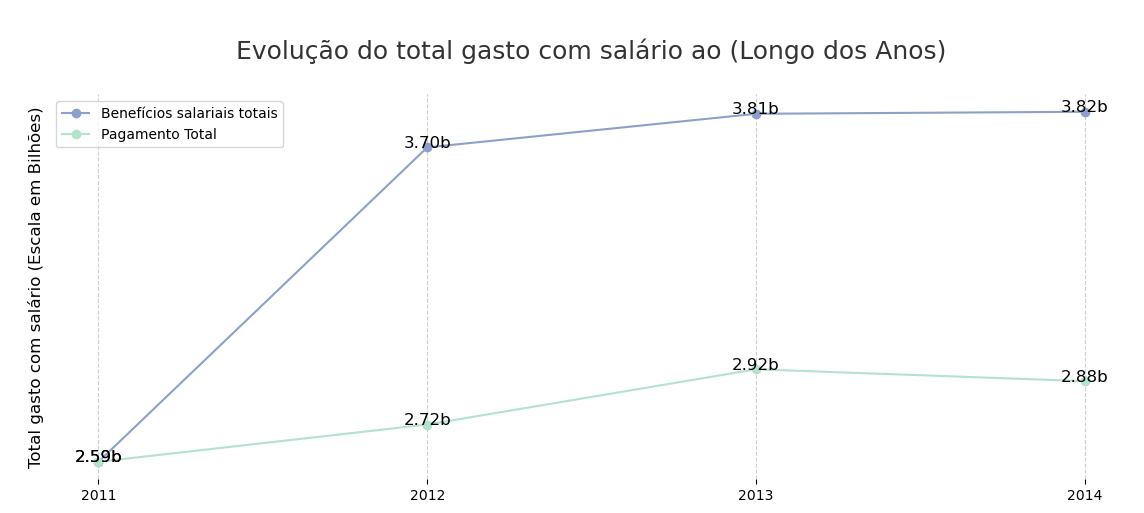

In [170]:
def exibir_grafico_linha(base,altura):
    '''#### Funcao posiciona cada valor em formato de bilhoes<br>
       
        for x, y in zip(base, altura):
        
            valor_bilhoes = y / 1e9
            ax.text(x, y + 300, f"{valor_bilhoes:,.2f}b".replace(',','.'),
            ha='center',
            fontsize=12,color='black')
'''
    for x, y in zip(base, altura):

        valor_bilhoes = y / 1e9
        ax.text(x, y + 150, f"{valor_bilhoes:,.2f}b".replace(',','.'), ha='center', fontsize=12,color='black')


tabela_salario = tabela.groupby('Year')[['TotalPay','TotalPayBenefits']].sum()
pagamento_total = tabela_salario['TotalPay'].values
beneficios_salariais_totais = tabela_salario['TotalPayBenefits'].values


fig, ax = plt.subplots(figsize=(14,5))
ax.plot(year, beneficios_salariais_totais, marker='o', color=paletas[2], label="Benefícios salariais totais")
ax.plot(year, pagamento_total, marker='o', label="Pagamento Total")


# Adicionando rótulos diretamente nos pontos dos graficos de linha
exibir_grafico_linha(year,pagamento_total)
exibir_grafico_linha(year,beneficios_salariais_totais)

# Configurações
ax.set_title("\nEvolução do total gasto com salário ao (Longo dos Anos)\n", fontsize=18,alpha=0.8)

# Dividi os valores de x com year[len(year)//4] - 0.5
# Ajustei a altura de y com max(pagamento_total) - 150



# ax.text(year[len(year)//4] - 0.5, max(pagamento_total) - 150,"O time aumentou em {:.1%}.▲".format(crescimento),fontsize=14,color=paletas[2],ha='center')
ax.set_ylabel("\nTotal gasto com salário (Escala em Bilhões)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])
ax.legend()

# Aplica formatação personalizada às colunas de médias no DataFrame.
tabela_salario['TotalPay'] = tabela_salario['TotalPay'].apply(formatacao)
tabela_salario['TotalPayBenefits'] = tabela_salario['TotalPayBenefits'].apply(formatacao)
display(tabela_salario)

plt.show()

**Gasto Total com Salários:**

* **Aumento:** O gasto total com salários aumentou significativamente ao longo dos anos, com uma pequena desaceleração nos anos de 2013 e 2014. Apesar de estar em linha com o crescimento do número de funcionários e dos salários médios como já mencionado, essa desaceleração não impactou tanto o gasto total com salários, que saiu de uma linha crescente linear correlativa. Isso indica uma tendência de estabilização e pode apontar para um cenário mais padrão e saudável para as finanças.

Ou tiveram demissões ou reajustes nos cargos de maiores salários. Deve ser por esse motivo que, mesmo com o aumento no número de funcionários, essa soma não foi impactada.


##### 5. Prever, nesse ritmo, a evolução dos salários médios nos próximos 5 anos?

- Antes de partir para a criação do modelo de previsão, quero explorar como as correlações estão se comportando entre as diferentes colunas da base de dados.

- Com um total de 148 mil linhas disponíveis, minha ideia é aproveitar ao máximo essas informações, evitando excluir dados desnecessariamente e garantindo que as análises sejam robustas e completas.

In [162]:
#  é importante usar .copy() para evitar alterações indesejadas no tabela_salarios
tabela_para_previsao = tabela_salarios[['JobTitle', 'BasePay', 'OtherPay', 
                                        'Benefits', 'TotalPay', 'TotalPayBenefits', 'Year']].copy()

# Substituir valores 'NaN' em 'Benefits' por 0
# O método fillna é ideal para lidar com valores ausentes (NaN) em colunas. 
# Ele substitui todos os NaN de forma eficiente.
tabela_para_previsao['Benefits'] = tabela_para_previsao['Benefits'].fillna(0)

# Remover valores vazios caso fique algum nan pendente
tabela_para_previsao = tabela_para_previsao.dropna()

- Uma das colunas que escolhi analisar para entender seu impacto nos resultados foi 'Benefícios'. Ela contém 36 mil valores ausentes, o que representa 24% da base. Em vez de simplesmente ignorar esses dados e perder um insight valioso, decidi transformá-los de 'NaN' para '0.0'.

- Percebi que, em 2011, os funcionários não receberam benefícios, então faz mais sentido preservar essa informação do que descartar um ano inteiro de análise.

In [163]:
# Exibir os primeiros registros
display(tabela_para_previsao.head())

,JobTitle,BasePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,400184.25,0.0,567595.43,567595.43,2011
1,CAPTAIN III (POLICE DEPARTMENT),155966.02,137811.38,0.0,538909.28,538909.28,2011
2,CAPTAIN III (POLICE DEPARTMENT),212739.13,16452.60,0.0,335279.91,335279.91,2011
3,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,198306.90,0.0,332343.61,332343.61,2011
4,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,182234.59,0.0,326373.19,326373.19,2011


In [164]:
tabela_para_previsao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148045 entries, 0 to 148653
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   JobTitle          148045 non-null  object 
 1   BasePay           148045 non-null  float64
 2   OtherPay          148045 non-null  float64
 3   Benefits          148045 non-null  float64
 4   TotalPay          148045 non-null  float64
 5   TotalPayBenefits  148045 non-null  float64
 6   Year              148045 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 9.0+ MB


- Com os valores nulos resolvidos, é hora de analisar mais de perto as colunas JobTitle e Year . Ambas precisam ser ajustadas para que seus valores façam sentido no modelo. Por exemplo, o ano de 2012 seria interpretado pelo modelo como 2.012 mil, o que não faz sentido.

- A solução é agrupar os valores repetidos, criando uma lista de ocorrências, algo como [1, 2, 3, 4, 4, 2, 2, 2...]. Para isso, usarei o método factorize(), que é perfeito para classificar valores categóricos e transformá-los em arrays numéricos.

In [165]:
# Classificando e modificando a mesma coluna

'''JobTitle'''
tabela_para_previsao['JobTitle'] = pd.factorize(tabela_para_previsao['JobTitle'])[0]  # passa um np.ndarray
tabela_para_previsao['JobTitle'] += 1  # para começar com o número 1

'''Year'''
tabela_para_previsao['Year'] = pd.factorize(tabela_para_previsao['Year'])[0]  # passa um np.ndarray
tabela_para_previsao['Year'] += 1  # para começar com o número 1

display(tabela_para_previsao.head())

,JobTitle,BasePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,1,167411.18,400184.25,0.0,567595.43,567595.43,1
1,2,155966.02,137811.38,0.0,538909.28,538909.28,1
2,2,212739.13,16452.60,0.0,335279.91,335279.91,1
3,3,77916.00,198306.90,0.0,332343.61,332343.61,1
4,4,134401.60,182234.59,0.0,326373.19,326373.19,1


In [166]:
tabela_para_previsao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148045 entries, 0 to 148653
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   JobTitle          148045 non-null  int64  
 1   BasePay           148045 non-null  float64
 2   OtherPay          148045 non-null  float64
 3   Benefits          148045 non-null  float64
 4   TotalPay          148045 non-null  float64
 5   TotalPayBenefits  148045 non-null  float64
 6   Year              148045 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 9.0 MB


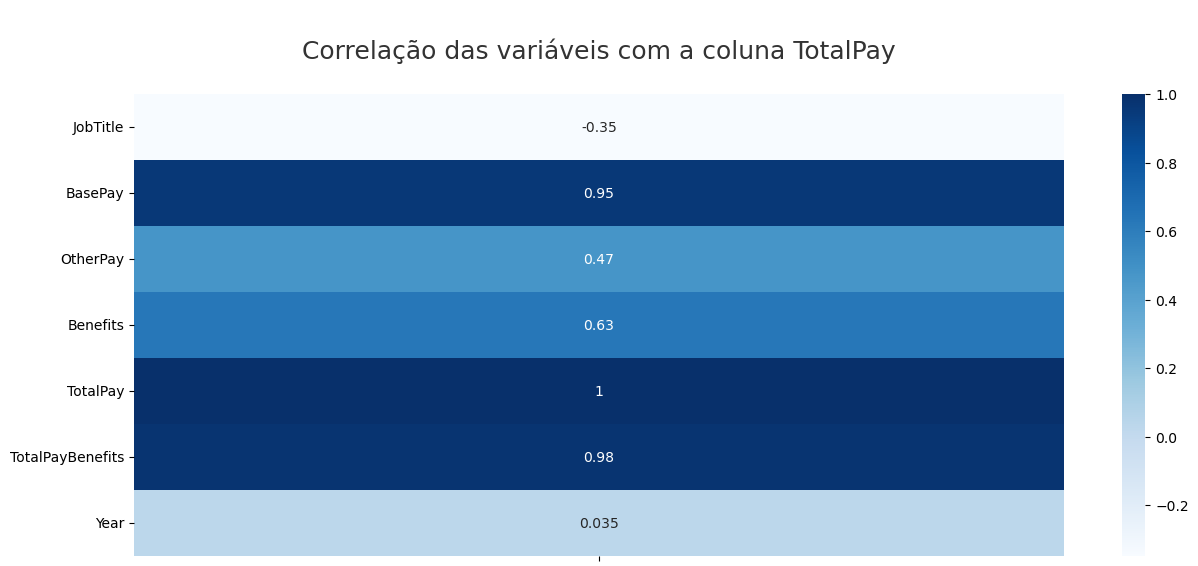

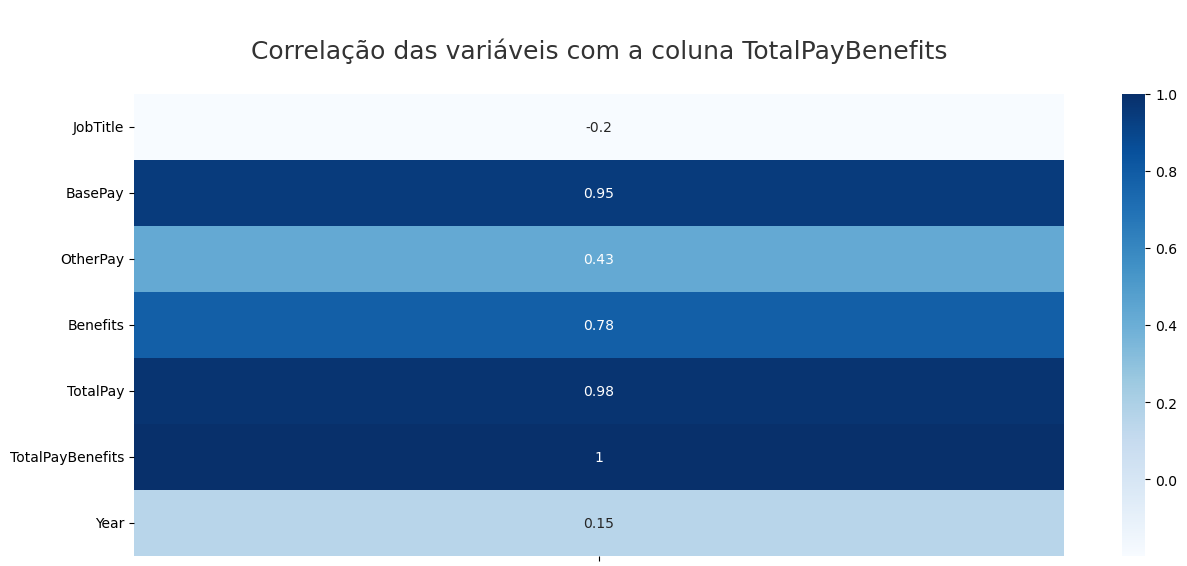

In [167]:
# Chamar função de correlação
grafico_corr(tabela_para_previsao,'TotalPay')
grafico_corr(tabela_para_previsao,'TotalPayBenefits')

- Os resultados das correlações ficaram incríveis e revelaram alguns insights inesperados. Uma surpresa foi a baixa influência das colunas JobTitle e Year nos salários, algo que eu imaginava que teria mais impacto, mas não foi o caso.

- Por outro lado, a coluna BasePay mostrou uma forte correlação, com quase 95% de impacto nos salários. Já a coluna Benefits também se destacou positivamente, com uma correlação entre 65% e 78%. Isso reforça que valeu muito a pena incluí-la na análise, mesmo com os valores ausentes ajustados!

Criando o modelo de previsão

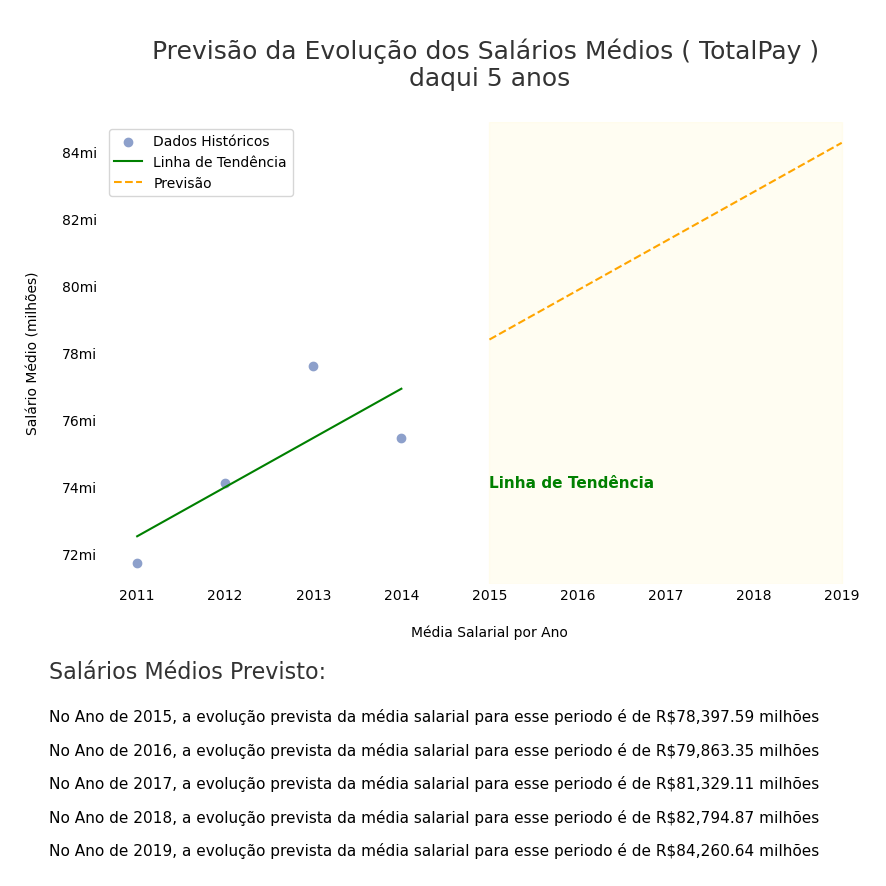

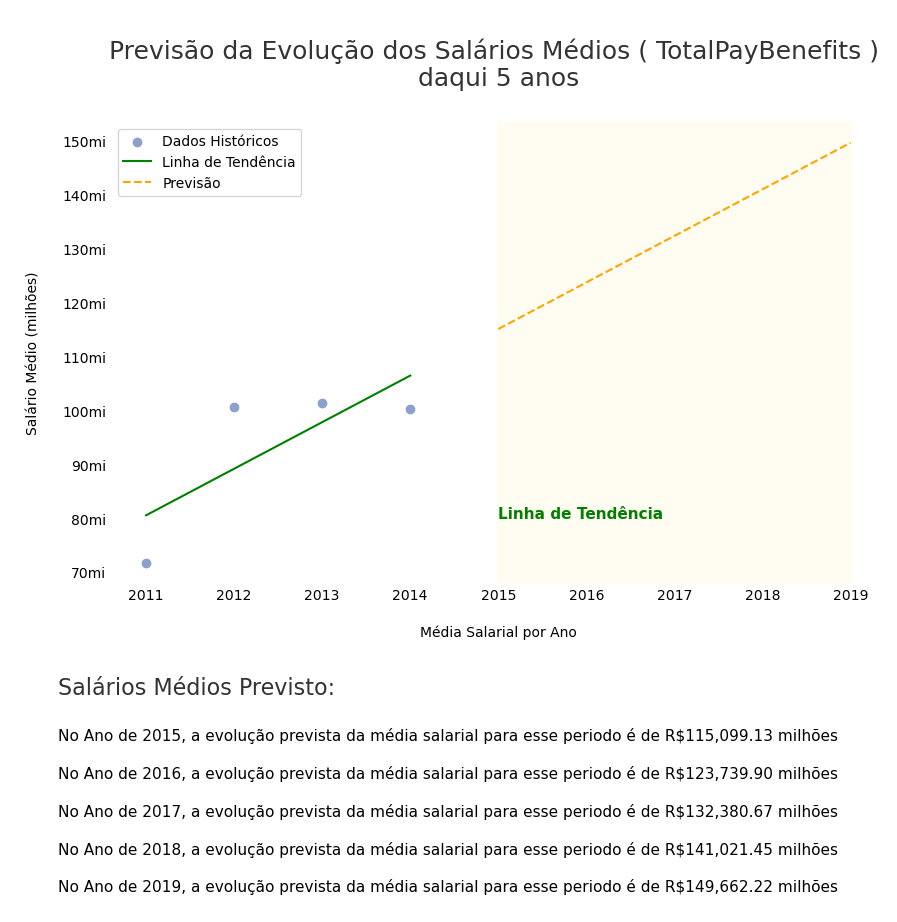

In [168]:

tabela_mediao_salarios = tabela.groupby('Year')[['TotalPay','TotalPayBenefits']].mean()
anos = np.array([2011, 2012, 2013, 2014]).reshape(-1, 1)
TotalPay = np.array(tabela_mediao_salarios['TotalPay'].values)  # Exemplos em milhões
TotalPayBenefits = np.array(tabela_mediao_salarios['TotalPayBenefits'].values)  # Exemplos em milhões


valores = {'TotalPay':TotalPay,
           'TotalPayBenefits':TotalPayBenefits}


# Treinando o modelo de regressão linear
for valor in valores:
    modelo = LinearRegression()
    modelo.fit(anos, valores[valor])

    # Exemplo de uso
    array1 = modelo.predict(anos)  # Resultado do modelo
    array2 = previsoes  # Previsões futuras


    # Previsões para os próximos 5 anos
    anos_futuros = np.array([2015,2016,2017,2018,2019]).reshape(-1, 1)
    previsoes = modelo.predict(anos_futuros)


    # Criação e Edição do Gráfico
    plt.figure(figsize=(10, 6))
    plt.scatter(anos, valores[valor], label='Dados Históricos',color=paletas[2])
    plt.plot(anos, modelo.predict(anos), color='green', label='Linha de Tendência')
    plt.plot(anos_futuros, previsoes, color='orange', linestyle='--', label='Previsão')

    
    
    plt.axvspan(2015, 2019, color=cores[5], alpha=0.15)
    plt.text(2015, posicao_y(2), 'Linha de Tendência', fontsize=11, color='green', weight='bold')
    posicao_inicial_y = posicao_y(0)

    # Aplica a formatação personalizada ao eixo Y.
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

    plt.tick_params(axis='y',length=0)
    plt.tick_params(axis='x', length=0)

    plt.title(f'\nPrevisão da Evolução dos Salários Médios ( {valor} ) \ndaqui 5 anos\n',fontsize=18,alpha=0.8)
    plt.ylabel('\nSalário Médio (milhões)\n')
    plt.xlabel('\nMédia Salarial por Ano\n')
    plt.legend()

    plt.box(False)# retirar as bordas do gráfico
    
    
   # Exibindo os resultados
    acrescimo = 7 if valor == 'TotalPayBenefits' else 1
    posicao_inicial_y -= 2500*acrescimo
    plt.text(2010, posicao_inicial_y, "Salários Médios Previsto:\n", fontsize=16,alpha=0.8)

    for ano, salario in zip(anos_futuros.flatten(), previsoes):

        posicao_inicial_y -= 1000*acrescimo
        plt.text(2010, posicao_inicial_y, f"No Ano de {ano}, a evolução prevista da média salarial para esse periodo é de R${salario:,.2f} milhões\n", fontsize=11)

    plt.show()

    

## Análise da Previsão de Salários Médios e Proposta de Ação

Ao observar o gráfico de previsão da evolução dos salários médios (TotalPay, TotalPayBenefits) para os próximos cinco anos, é evidente que a empresa tem mantido um crescimento linear e consistente nos últimos quatro anos. Essa trajetória não apenas reflete uma gestão sólida, mas também reforça a confiabilidade no modelo de previsão.

#### Pontos de destaque:

- Crescimento Linear :

    - A linha de tendência reflete um aumento constante nos períodos médios ao longo dos anos.
    - A previsão para 2019 é de R$ 84.260,64 milhões , indicando um crescimento médio anual.

- Metodologia Consistente :

    - A continuidade dos padrões ao longo do tempo demonstra que as estratégias atuais estão funcionando bem para manter esse crescimento.


#### Proposta:

- Para garantir que os valores previstos possam se tornar realidade, a recomendação é alinhar as ações com a metodologia que a empresa já aplica com sucesso. Aqui estão algumas sugestões:

- Investir no Salário Base : Manter o foco em aumentar gradualmente o salário base, pois ela tem o maior impacto na composição do TotalPay e TotalPayBenefits, conforme a análise de correlação.

- Valorizar os Benefícios : Os Benefits também mostraram uma influência significativa. Expandir ou melhorar os pacotes de benefícios pode contribuir para atingir a previsão, além de aumentar a satisfação dos funcionários.

- Monitorar e Ajustar Periodicamente :

    - Realizar revisões anuais para comparar os resultados reais com a variação e ajustar as estratégias, se necessário.
    - Garantir que o modelo permaneça atualizado com a realidade do mercado e com as prioridades da empresa.

- Comunicação Interna : Informar aos colaboradores sobre a meta de crescimento e como isso reflete diretamente na valorização do tempo pode engajar ainda mais a equipe.
